## Initialization

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import chi2, kstest, norm
import seaborn as sns
import math
import scipy.stats as stats

## 1) Crude Monte Carlo

In [191]:
np.random.seed(1234)

def MonteCarlo(n):
    U = np.random.uniform(0, 1, n)
    X = np.exp(U)
    mean = np.mean(X)
    std = np.std(X)
    standard_error = std / np.sqrt(n)
    conf_int = (mean - 1.96 * standard_error, mean + 1.96 * standard_error)
    return mean, conf_int


mean, conf_int = MonteCarlo(100)
print(mean)
print(np.round(conf_int,2))



1.743309935963331
[1.65 1.84]


## Antithetic Variables

In [192]:
np.random.seed(1234)
def AntitheticVariables(n):

    U = np.random.uniform(0, 1, n//2)
 
    U = np.concatenate([U, 1-U])

    X = np.exp(U)

    mean = np.mean(X)
    std = np.std(X)
    standard_error = std / np.sqrt(n)
    conf_int = (mean - 1.96 * standard_error, mean + 1.96 * standard_error)

    return mean, conf_int


mean, conf_int = AntitheticVariables(100)
print(mean)
print(np.round(conf_int,2))

1.7091022622154748
[1.62 1.8 ]


## Control Variable

In [204]:
np.random.seed(1234)
def ControlVariables(n):

    U = np.random.uniform(0, 1, n//2)

    X = np.exp(U)
    Y = U

    mu_y = 0.5

    #Value taken from slides
    c = -0.14086/np.var(Y)
    
    Z = X + c * (Y - mu_y)

    mean = np.mean(Z)
    std = np.std(Z)
    standard_error = std / np.sqrt(n)
    conf_int = (mean - 1.96 * standard_error, mean + 1.96 * standard_error)

    return mean, conf_int


mean, confidence_interval = ControlVariables(100)
print(mean)
print(np.round(confidence_interval,2))

1.7022804275888808
[1.68 1.72]


## Stratified Sampling

In [205]:
np.random.seed(1234)
def StratifiedSampling(n):

    k = 10  
    N = n // k

    samples = []
    for i in range(k):
        StratifiedSamples = np.random.uniform(i / k, (i + 1) / k, N)
        samples.extend(StratifiedSamples)

    U = np.array(samples)

    X = np.exp(U)

    mean = np.mean(X)
    std = np.std(X)
    standard_error = std / np.sqrt(n)
    conf_int = (mean - 1.96 * standard_error, mean + 1.96 * standard_error)

    return mean, conf_int


mean, conf_int = StratifiedSampling(100)
print(mean)
print(np.round(conf_int,2))

1.7207447330229444
[1.62 1.82]


## Summary of methods

In [206]:
n = 100
np.random.seed(123)
print('True Mean Value:')
print('1.72 \n')

print('Monte Carlo:')
mean, confidence_interval = MonteCarlo(n)
print(np.round(mean,4),'          ',np.round(confidence_interval,2),'        ',np.round(np.abs(mean-1.72),4),'         ',np.round(np.abs(confidence_interval[0]-confidence_interval[1]),4),'\n')

print('Antithetic Variables:')
mean, confidence_interval = AntitheticVariables(n)
print(np.round(mean,4),'          ',np.round(confidence_interval,2),'        ',np.round(np.abs(mean-1.72),4),'         ',np.round(np.abs(confidence_interval[0]-confidence_interval[1]),4),'\n')

print('Control Variables:')
mean, confidence_interval = ControlVariables(n)
print(np.round(mean,4),'          ',np.round(confidence_interval,2),'        ',np.round(np.abs(mean-1.72),4),'         ',np.round(np.abs(confidence_interval[0]-confidence_interval[1]),4),'\n')

print('Stratified Sampling:')
mean, confidence_interval = StratifiedSampling(n)
print(np.round(mean,4),'          ',np.round(confidence_interval,2),'        ',np.round(np.abs(mean-1.72),4),'         ',np.round(np.abs(confidence_interval[0]-confidence_interval[1]),4),'\n')

True Mean Value:
1.72 

Monte Carlo:
1.7014            [1.62 1.78]          0.0186           0.1643 

Antithetic Variables:
1.7153            [1.62 1.81]          0.0047           0.1889 

Control Variables:
1.7161            [1.7  1.73]          0.0039           0.0237 

Stratified Sampling:
1.7171            [1.62 1.81]          0.0029           0.1947 



## Redusing Variance of Exercise 4 with control variates

In [76]:
# Parameters
m = 10                  
mst = 8   
mtbc = 1 
N = 100000  
n= 10   

# set seed
np.random.seed(123)

def Exp_service_time(mst):
    return np.random.exponential(mst)

def Run_Poisson_Sim(m,mst,mtbc,n,N,service_dist):
    expected_service_time = mst

    blocked_fractions = []
    total_service_time = []
    
    for _ in range(n):
        # Initialize parameters 
        t = 0
        blocked_customers = 0
        tot_ser_time = 0
        busy_until = [0] * m

        for _ in range(N):
            t += np.random.exponential(mtbc)
            
            available_server = -1
            for i in range(m):
                if busy_until[i] <= t:
                    available_server = i
                    break
            
            if available_server == -1:
                
                blocked_customers += 1
            else:
                
                service_time = service_dist()
                tot_ser_time += service_time
                busy_until[available_server] = t + service_time


        blocked_fractions.append(blocked_customers / N)
        total_service_time.append(tot_ser_time/N)
    

    mean_blocked = np.mean(blocked_fractions)
    mean_service_time = np.mean(total_service_time)

    variance_control_var = np.var(total_service_time)
    if variance_control_var == 0:
        raise ValueError("Control variable has zero variance, choose a different control variate.")

    cov = np.cov(blocked_fractions, total_service_time)[0, 1]
    var = np.var(total_service_time)
    alpha = cov / var

    adjusted_blocking_fractions = [
    bf - alpha * (cv - expected_service_time)
    for bf, cv in zip(blocked_fractions, total_service_time)
    ]  

    #variance before 
    varX = np.var(blocked_fractions)

    #variance after
    varZ = varX - ((cov**2)/var )

    print('variance of X: ', varX)
    print('variance of Z: ', varZ)

    mean = np.mean(adjusted_blocking_fractions)
    std= np.std(adjusted_blocking_fractions)
    conf_int = stats.norm.interval(0.95, loc=mean, scale=std / np.sqrt(n))

    return adjusted_blocking_fractions,mean, conf_int

generator = lambda: Exp_service_time(mst)
# Run simulations
blocked_fractions_1,mean_1, conf_int_1 = Run_Poisson_Sim(m,mst, mtbc,n,N,generator) 

variance of X:  2.421484000000001e-06
variance of Z:  2.147183138949097e-06


## 6) 

In [207]:
#Function for hyper exponential distribution
def Generate_numbers(seed, mtbc, p1, lambda1, p2, lambda2):
    np.random.seed(seed)
    t1 = np.random.poisson(mtbc)
    if np.random.rand() < p1:
        t2 = np.random.exponential(1/lambda1)
    else:
        t2 = np.random.exponential(1/lambda2)
    
    return t1, t2
    


def CommonRandomNumbers(m,mst,mtbc,n,N,service_dist):
    
    blocked_fractions_poi = []
    blocked_fractions_hype = []
    
    # Hyper-exponential parameters
    p1, lambda1 = 0.8, 0.8333
    p2, lambda2 = 0.2, 5.0

    for _ in range(n):
        seed = np.random.randint(0,10000000,size=N)
        # Initialize parameters 
        t_poi = 0
        blocked_customers_poi = 0
        busy_until_poi = [0] * m

        t_hyp = 0
        blocked_customers_hyp = 0
        busy_until_hyp = [0] * m
        
        for j in range(N):

            t1,t2 = Generate_numbers(seed[j],mtbc, p1, lambda1, p2, lambda2)

            t_poi += t1
            
            t_hyp += t2
            
            
            available_server_poi = -1
            for i in range(m):
                if busy_until_poi[i] <= t_poi:
                    available_server_poi = i
                    break
            
            if available_server_poi == -1:
                blocked_customers_poi += 1
            else:
                service_time = service_dist()
                busy_until_poi[available_server_poi] = t_poi + service_time

            available_server_hyp = -1
            for i in range(m):
                if busy_until_hyp[i] <= t_hyp:
                    available_server_hyp = i
                    break
            
            if available_server_hyp == -1:
                blocked_customers_hyp += 1
            else:
                service_time = service_dist()
                busy_until_hyp[available_server_hyp] = t_hyp + service_time
        
        blocked_fractions_poi.append(blocked_customers_poi / N)
        blocked_fractions_hype.append(blocked_customers_hyp / N)
    
    
    mean_poi = np.mean(blocked_fractions_poi)
    mean_hype = np.mean(blocked_fractions_hype)
    
    std_poi= np.std(np.array(blocked_fractions_poi))
    std_hyp = np.std(np.array(blocked_fractions_hype))

    conf_int_poi = stats.norm.interval(0.95, loc=mean_poi, scale=std_poi / np.sqrt(n))
    conf_int_hyp = stats.norm.interval(0.95, loc=mean_hype, scale=std_hyp / np.sqrt(n))

    return mean_poi, mean_hype,conf_int_poi, conf_int_hyp

generator = lambda: Exp_service_time(mst)
# Run simulations
mean_poi, mean_hype,conf_int_poi, conf_int_hyp = CommonRandomNumbers(m,mst, mtbc,n,N,generator) 

# Print results
print(f"Mean Poisson: {mean_poi:.4f}")
print(f"Mean Hyper: {mean_hype:.4f}")

print(f"95% confidence interval Poisson: ({conf_int_poi[0]:.4f}, {conf_int_poi[1]:.4f})")
print(f"95% confidence interval Hyper: ({conf_int_hyp[0]:.4f}, {conf_int_hyp[1]:.4f})")



Mean Poisson: 0.1302
Mean Hyper: 0.1378
95% confidence interval Poisson: (0.1291, 0.1313)
95% confidence interval Hyper: (0.1364, 0.1392)


## Exercise 7

In [128]:
from scipy.stats import norm

a = 2
print((1-norm.cdf(a,0,1))*100)

a = 4
print((1-norm.cdf(a,0,1))*100)
print(' ')
print((1-norm.cdf(2,2,1))*100)
print((1-norm.cdf(a,4,1))*100)



2.275013194817921
0.003167124183311998
 
50.0
50.0



Efficiency Discussion:
Importance sampling tends to be more efficient when the tails of the distribution are important. It achieves this by assigning higher probabilities to rare events, thereby reducing variance compared to crude Monte Carlo.


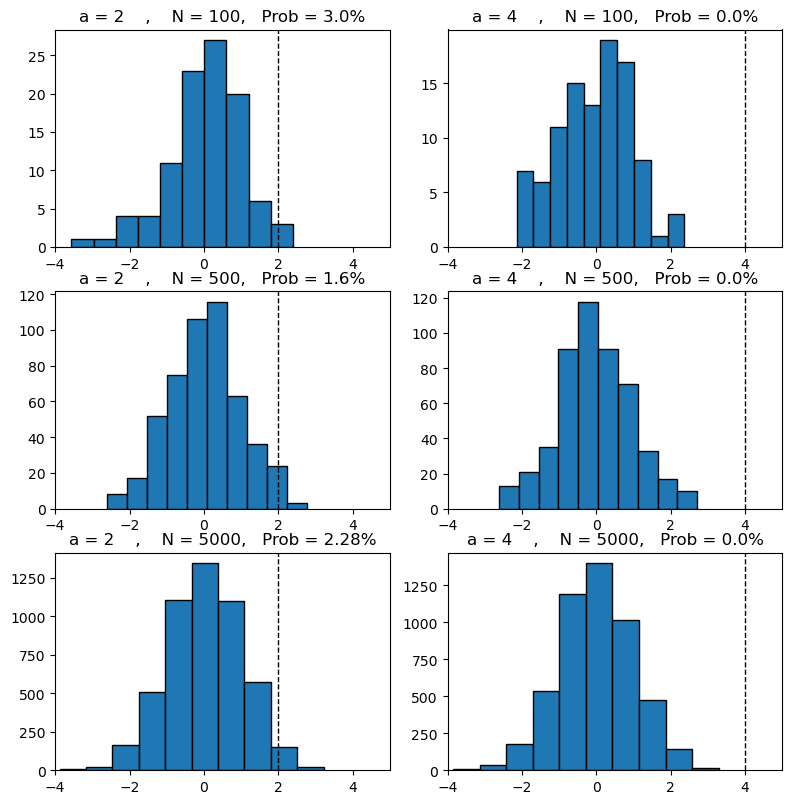

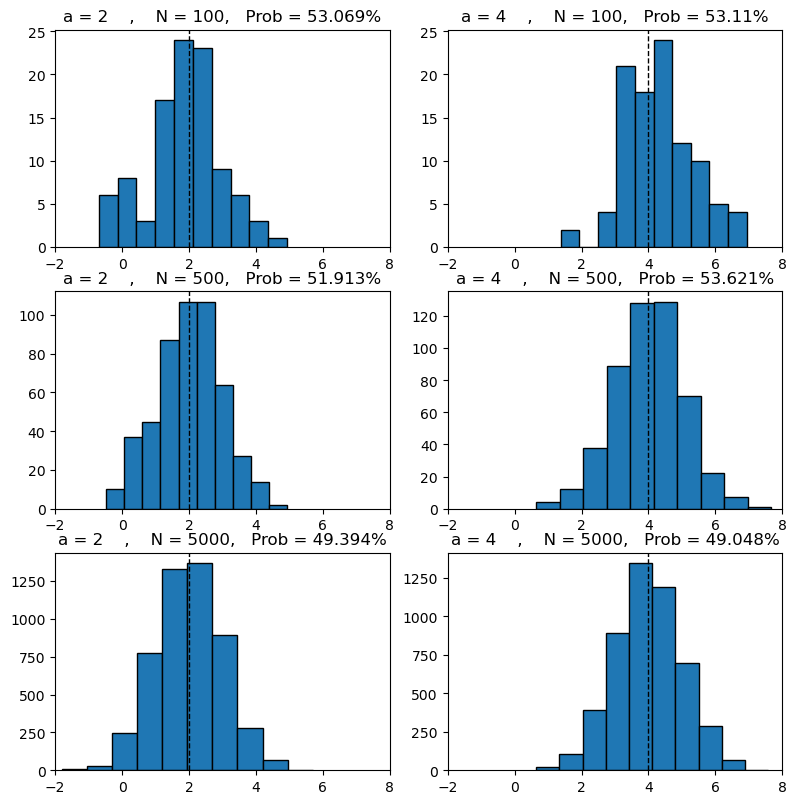

In [208]:
import numpy as np
import time
np.random.seed(1234)

def crude_monte_carlo(a, num_samples):
    samples = np.random.randn(num_samples)  
    probability = np.mean(samples > a)
    return samples, probability

# Importance sampling
def importance_sampling(a, sigma, num_samples):
    samples = np.random.normal(loc=a, scale=sigma, size=num_samples)  
    weights = np.exp(-0.5 * ((samples - a) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))  
    probability = np.mean((samples > a) * weights) / np.mean(weights)  
    return samples,probability

# Experimentation
sample_sizes = [100, 500, 5000]  
a_values = [2, 4]  
sigma_values = [1]  

figure, axis = plt.subplots(3, 2,figsize=(8, 8)) 
figure.tight_layout()
i = 0
j = 0
for num_samples in sample_sizes:
    j = 0
    for a in a_values:
        samples, crude_prob = crude_monte_carlo(a, num_samples)
        axis[i,j].hist(samples, edgecolor='black')
        axis[i,j].set_title(f'a = {a}    ,    N = {num_samples},   Prob = {np.round(crude_prob*100,3)}%')
        axis[i,j].axvline(a, color='black', linestyle='dashed', linewidth=1)
        axis[i,j].set_xlim([-4,5])
        j+=1
    i+=1

figure, axis = plt.subplots(3, 2,figsize=(8, 8)) 
figure.tight_layout()
i = 0
j = 0
for num_samples in sample_sizes:
    j = 0
    for a in a_values:
        samples, crude_prob =importance_sampling(a, 1, num_samples)
        axis[i,j].hist(samples, edgecolor='black')
        axis[i,j].set_title(f'a = {a}    ,    N = {num_samples},   Prob = {np.round(crude_prob*100,3)}%')
        axis[i,j].axvline(a, color='black', linestyle='dashed', linewidth=1)
        axis[i,j].set_xlim([-2,8])
        j+=1
    i+=1
        

# Efficiency Discussion
print("\nEfficiency Discussion:")
print("Importance sampling tends to be more efficient when the tails of the distribution are important. It achieves this by assigning higher probabilities to rare events, thereby reducing variance compared to crude Monte Carlo.")

## Exercise 8

In [209]:
U = np.random.uniform(0, 1, num_samples)
X = np.exp(U)
mean = np.mean(X)
print(mean)
# Original function f(x) = e^x
def f(x):
    return np.exp(x)

# Importance sampling function g(x) = lambda * exp(-lambda * x)
def g(x, lmbda):
    return lmbda * np.exp(-lmbda * x)

# Importance sampling estimator
def importance_sampling_estimator(lmbda, num_samples):
    samples = np.random.exponential(scale=1/lmbda, size=num_samples)  # generate samples from exponential distribution
    weights = f(samples) / g(samples, lmbda)  # compute importance weights
    estimate = np.mean(weights)
    return estimate

# Parameters
lmbda = 1  # lambda value for the exponential distribution
num_samples = 100000  # number of samples

# Estimate integral using importance sampling
estimate = importance_sampling_estimator(lmbda, num_samples)
print("Estimated value:", estimate/num_samples)

1.7200243316347406
Estimated value: 5.5622878192884455


In [151]:
import numpy as np

# Parameters
lambda_ = 1.0
N = 10000  # Number of samples

# Generate samples from g(x)
u = np.random.uniform(0, 1, N)
x_samples = -1/lambda_ * np.log(1 - u * (1 - np.exp(-lambda_)))

# Calculate weights
weights = np.exp(x_samples) * (1 - np.exp(-lambda_)) / (lambda_ * np.exp(-lambda_ * x_samples))

# Importance sampling estimate of the integral
integral_estimate = np.mean(weights)

integral_estimate


1.7314510376039718

In [189]:
import numpy as np
import scipy.optimize as opt

# Define the function to compute the variance for a given lambda
def variance_estimator(lambda_):
    I = np.exp(1) - 1  # Analytical value of the integral
    term1 = (1 - np.exp(-lambda_))**2 / (lambda_ * (lambda_ + 2))
    term2 = np.exp(lambda_ + 2) - 1
    variance = term1 * term2 - I**2
    return variance

# Optimize to find the lambda that minimizes the variance
result = opt.minimize_scalar(variance_estimator, bounds=(0.0, 10), method='bounded')
optimal_lambda = result.x
min_variance = result.fun

# Simulation to verify the optimal lambda
def importance_sampling(lambda_, N=10000):
    u = np.random.uniform(0, 1, N)
    x_samples = -1/lambda_ * np.log(1 - u * (1 - np.exp(-lambda_)))
    weights = np.exp(x_samples) * (1 - np.exp(-lambda_)) / (lambda_ * np.exp(-lambda_ * x_samples))
    integral_estimate = np.mean(weights)
    variance_estimate = np.var(weights)
    return integral_estimate, variance_estimate

# Perform the simulation
N = 10000
integral_estimate, variance_estimate = importance_sampling(optimal_lambda, N)

optimal_lambda, min_variance, integral_estimate, variance_estimate

(5.363445511637438e-06,
 -2.9524753083669952,
 1.7154877869121985,
 0.24377008175184461)